In [ ]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

import sys
import os
os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs

from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy.spatial.distance import pdist, squareform

import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import scanpy as sc


big_palette = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
    "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#FFFF00",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
]

print(torch.__version__)

Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
2.5.0+cu121


In [2]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)

    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls, stacked_linearized_all
    "PRETRAIN_ESM_CHECKPOINT_NAME": 
        #"facebook/esm2_t48_15B_UR50D", 
        "facebook/esm2_t36_3B_UR50D",
        # #"facebook/esm2_t33_650M_UR50D", 
        # #"facebook/esm2_t12_35M_UR50D", 
        # #"facebook/esm2_t6_8M_UR50D", 

    "UNIPROT_PATH": "/home/gdallagl/myworkdir/ESMSec/data/UniProt/human_proteome.tsv",
    "UNIPROT_CELLULAR_LOCATION_FORMATTED_PATH": "/home/gdallagl/myworkdir/ESMSec/data/UniProt/uniprotkb_reviewed_cellular_locations_formatted.csv"
}

# This 2 files are create by 00_make... script
config["PRECOMPUTED_EMBS_PATH"] = os.path.join(
    f"/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs",
    f"entire_reviewed_uniprot_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.safetensors"
)
config["PRECOMPUTED_EMBS_PATH_PROTEIN_NAMES"] = config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json')
config["PRECOMPUTED_EMBS_PATH_ADATA"] = config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '.h5ad')


# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Load Anndata

In [127]:
adata = sc.read_h5ad(config["PRECOMPUTED_EMBS_PATH_ADATA"])
adata

AnnData object with n_obs × n_vars = 20405 × 1000
    obs: 'protein', 'gene', 'Reviewed', 'Gene Names', 'Organism', 'Length', 'Protein names', 'sequence', 'truncated_sequence'
    uns: 'X_umap_all', 'X_umap_pca', 'neighbors_all', 'neighbors_pca', 'pca', 'vocabulary'
    obsm: 'X_latent', 'X_pca', 'X_umap_all', 'X_umap_pca'
    layers: 'attention_mask'
    obsp: 'neighbors_all_connectivities', 'neighbors_all_distances', 'neighbors_pca_connectivities', 'neighbors_pca_distances'

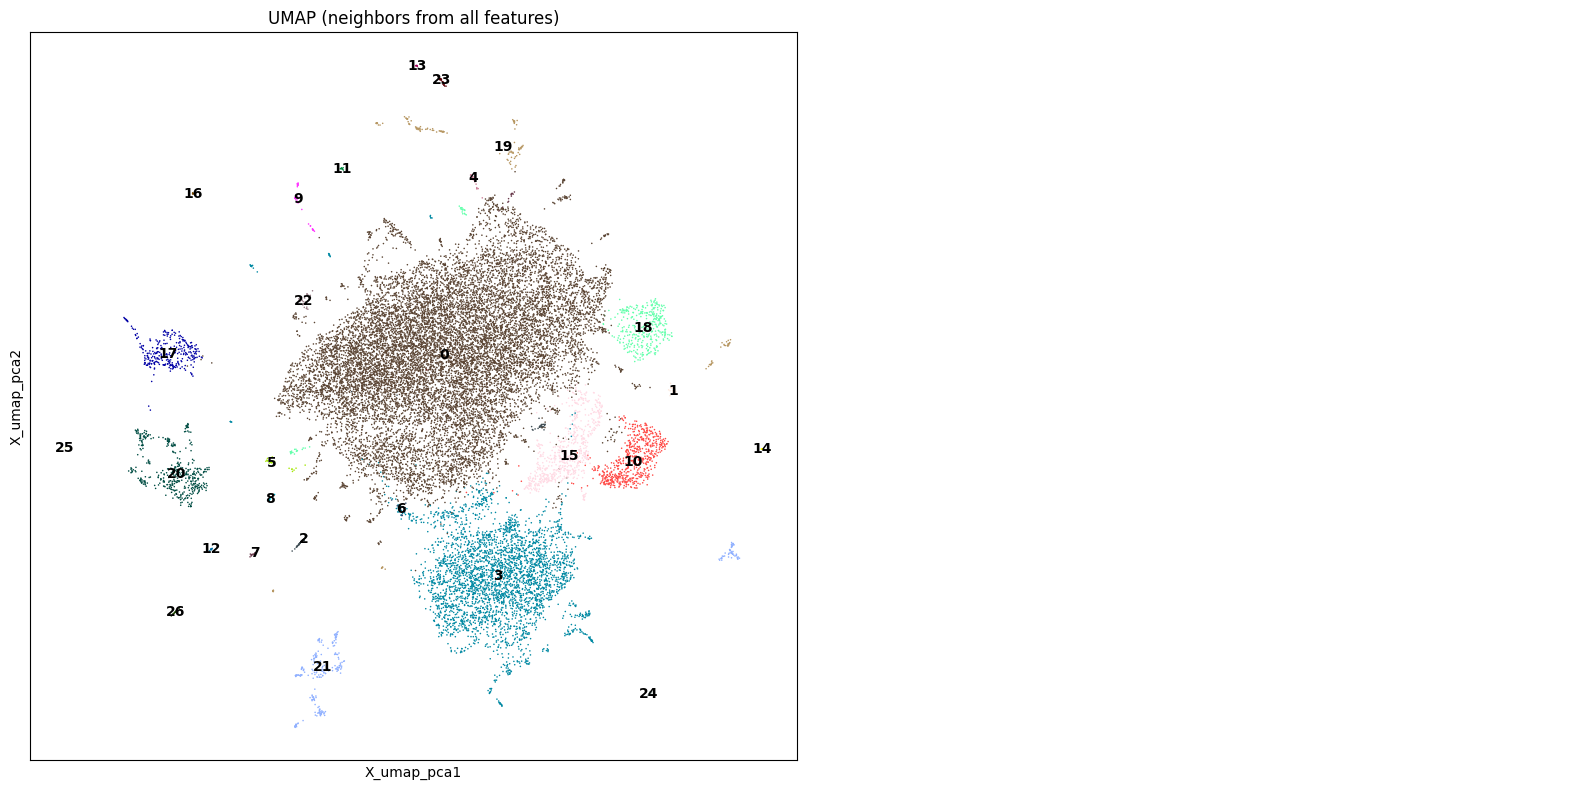

In [128]:
FEATURES = "pca"
KEY_OBS_CLUSTERS = F"leiden_{FEATURES}"

sc.tl.leiden(adata, resolution=0.1, neighbors_key=f"neighbors_{FEATURES}", key_added=KEY_OBS_CLUSTERS, flavor="igraph", n_iterations=2)

fig, axes = my_embs.plot_embeddings(
    adata,
    basis=[f"X_umap_{FEATURES}"],
    color=[f"leiden_{FEATURES}"],
    title=["UMAP (neighbors from all features)"],
    size=[5],
    palette=[big_palette],
    ncols=2,  # 2 columns, 2 rows
    figsize=(16, 8), 
    legend_loc=['on data'],
)
plt.show()

Interation 1
Interation 2


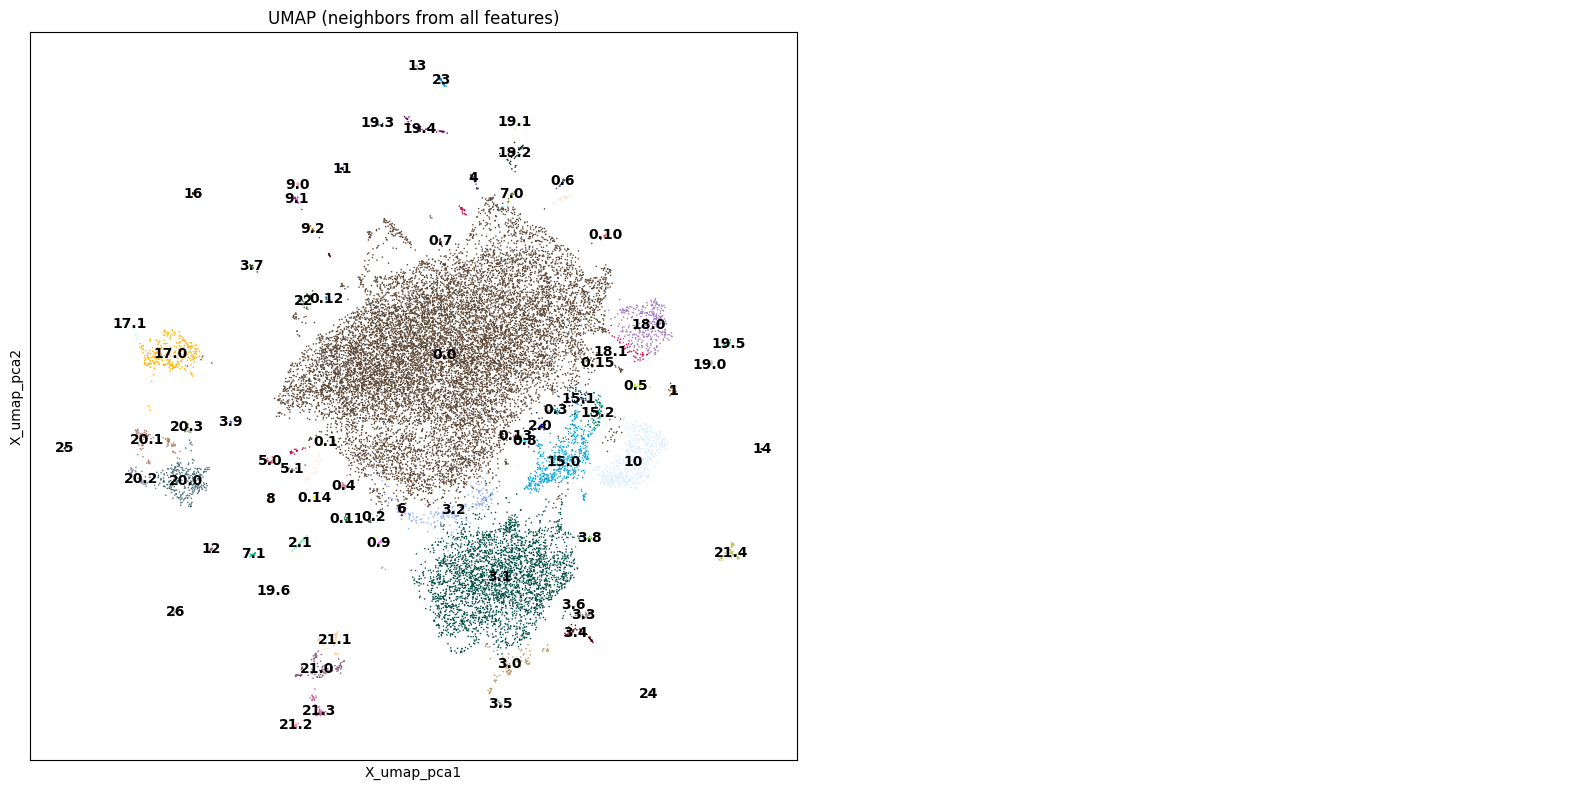

73


In [129]:

clusters_to_split = adata.obs[KEY_OBS_CLUSTERS].unique().tolist()

n_iter = 1
while len(clusters_to_split) != 0:

    print(f"Interation {n_iter}")

    new_clusters_to_split = []

    for c in clusters_to_split:

        # --- Subset ---
        adata_sub = adata[adata.obs[KEY_OBS_CLUSTERS] == str(c)].copy()

        # --- Check if splitting produced new subclusters ---
        if adata_sub.n_obs <= 10:
            #print(f"Skipping cluster {c} (too few cells: {adata_sub.n_obs})")
            continue

        # --- Neighbors ---
        #print(f"Calculating neighbors for cluster {c}...")
        sc.pp.neighbors(
            adata_sub,
            use_rep=f"X_{FEATURES}",
            n_neighbors=10,
            n_pcs=None,
            key_added=f"neighbors_{FEATURES}_new"
        )

        # --- Leiden clustering ---
        #print("Running Leiden...")
        sc.tl.leiden(
            adata_sub,
            resolution=0.1,
            neighbors_key=f"neighbors_{FEATURES}_new",
            key_added=f"{KEY_OBS_CLUSTERS}_new",
            flavor="igraph",
            n_iterations=2
        )

        # --- Check if splitting produced new subclusters ---
        if len(adata_sub.obs[f"{KEY_OBS_CLUSTERS}_new"].unique()) == 1:
            continue  # no further splitting needed

        # --- Combine old + new cluster labels ---
        combined_label = (
            adata_sub.obs[KEY_OBS_CLUSTERS].astype(str)
            + "."
            + adata_sub.obs[f"{KEY_OBS_CLUSTERS}_new"].astype(str)
        )

        # Update the original AnnData (matching indices)
        adata.obs[KEY_OBS_CLUSTERS] = adata.obs[KEY_OBS_CLUSTERS].astype(str) # need to not be categorical
        adata.obs.loc[adata_sub.obs_names, KEY_OBS_CLUSTERS] = combined_label

        # --- Add to further splitting list ---
        new_clusters_to_split.extend(adata_sub.obs[f"{KEY_OBS_CLUSTERS}_new"].unique().tolist())

    clusters_to_split = new_clusters_to_split
    #print(f"Next iteration clusters to split: {clusters_to_split}")
    n_iter +=1



fig, axes = my_embs.plot_embeddings(
    adata,
    basis=[f"X_umap_{FEATURES}"],
    color=[KEY_OBS_CLUSTERS],
    title=["UMAP (neighbors from all features)"],
    size=[5],
    palette=[big_palette],
    ncols=2,  # 2 columns, 2 rows
    figsize=(16, 8), 
    legend_loc=['on data'],
)
plt.show()
print(adata.obs[KEY_OBS_CLUSTERS].nunique())

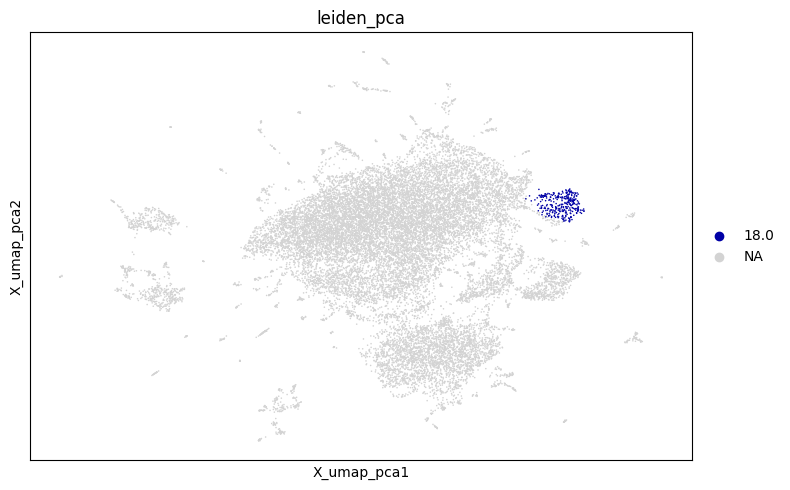

UniProt ID   Gene         Function
O14628       ZNF195       May be involved in transcriptional regulation. -!- SUBCELLULAR LOCATION: Nucleus {ECO:0000305}. -!- ALTERNATIVE PRODUCTS: Event=Alternative splicin...
O43296       ZNF264       May be involved in transcriptional regulation. -!- INTERACTION: O43296; Q8NHQ1: CEP70; NbExp=4; IntAct=EBI-4395808, EBI-739624; O43296; Q92997: DVL...
O94892       ZNF432 {ECO:0000312|HGNC:HGNC:20810} Homologous recombination repressor that functions as a poly(ADP-ribose) (PAR) reader regulating DNA damage response and PARP inhibition. Once recru...
P13682       ZNF35        May be involved in transcriptional regulation. Involved in cell differentiation and/or proliferation. -!- INTERACTION: P13682; Q9Y4X5: ARIH1; NbExp...
P15622       ZNF250       May be involved in transcriptional regulation. -!- INTERACTION: P15622-3; Q9ULJ7-2: ANKRD50; NbExp=3; IntAct=EBI-10177272, EBI-12239063; P15622-3; ...
...


In [141]:
# Investiagte single cluster
CLUSTER = "18.0"

fig, axes = my_embs.plot_embeddings(
    adata,
    basis=[f"X_umap_{FEATURES}"],
    color=[KEY_OBS_CLUSTERS],
    #title=["Secreted Status"],
    size=[5],
    palette=[["#0000A6"]],
    ncols=1,  # 2 columns, 2 rows
    figsize=(8, 5), 
    groups=[CLUSTER],
)
plt.show()

uniprot_ids = adata.obs[adata.obs[KEY_OBS_CLUSTERS] == CLUSTER].index

print(f"{'UniProt ID':<12} {'Gene':<12} {'Function'}")
print("="*100)
for uid in uniprot_ids[:5]:
    gene, func = mf.get_uniprot_info(uid)
    print(f"{uid:<12} {gene:<12} {func}")
print("...")

# GO enrichement

Running GO enrichment for 73 clusters...

Processing cluster 15.0...
  Found 429 unique genes in cluster

  Top terms for GO_Biological_Process_2021:
    - negative regulation of execution phase of apoptosis (GO:1900118): p=1.43e-10
    - regulation of execution phase of apoptosis (GO:1900117): p=2.17e-09
    - negative regulation of cyclin-dependent protein kinase activity (GO:1904030): p=1.00e+00

  Top terms for GO_Cellular_Component_2021:
    - cytosolic large ribosomal subunit (GO:0022625): p=1.00e+00
    - large ribosomal subunit (GO:0015934): p=1.00e+00
    - septin cytoskeleton (GO:0032156): p=1.00e+00
  Error with GO_Molecular_Function_2021: Error sending gene list, try again later

Processing cluster 3.0...
  Found 92 unique genes in cluster

  Top terms for GO_Biological_Process_2021:
    - regulation of immune response (GO:0050776): p=1.16e-29
    - neutrophil activation involved in immune response (GO:0002283): p=1.23e-08
    - regulation of cytokine production (GO:0001817

2025-11-07 16:46:57,941 [ERROR] Error fetching enrichment results: GO_Cellular_Component_2021
2025-11-07 16:47:35,373 [ERROR] Error fetching enrichment results: GO_Cellular_Component_2021


  Error with GO_Cellular_Component_2021: Expecting value: line 1 column 1 (char 0)

  Top terms for GO_Molecular_Function_2021:
    - MHC class Ib protein binding (GO:0023029): p=6.94e-07
    - protein phosphatase binding (GO:0019903): p=1.18e-06
    - MHC protein binding (GO:0042287): p=1.33e-06

Processing cluster 3.1...
  Found 2975 unique genes in cluster

  Top terms for GO_Biological_Process_2021:
    - extracellular matrix organization (GO:0030198): p=7.22e-163
    - extracellular structure organization (GO:0043062): p=1.29e-144
    - external encapsulating structure organization (GO:0045229): p=7.30e-142

  Top terms for GO_Cellular_Component_2021:
    - collagen-containing extracellular matrix (GO:0062023): p=7.86e-206
    - endoplasmic reticulum lumen (GO:0005788): p=5.19e-154
    - integral component of plasma membrane (GO:0005887): p=1.16e-105

  Top terms for GO_Molecular_Function_2021:
    - receptor ligand activity (GO:0048018): p=8.66e-150
    - cytokine activity (GO:00

2025-11-07 16:48:50,621 [ERROR] Error fetching enrichment results: GO_Molecular_Function_2021
2025-11-07 16:48:50,699 [ERROR] Error fetching enrichment results: GO_Molecular_Function_2021


  Error with GO_Molecular_Function_2021: Expecting value: line 1 column 1 (char 0)

Processing cluster 3.3...
  Found 36 unique genes in cluster

  Top terms for GO_Biological_Process_2021:
    - defense response to bacterium (GO:0042742): p=6.61e-15
    - defense response to Gram-negative bacterium (GO:0050829): p=1.27e-11
    - antimicrobial humoral immune response mediated by antimicrobial peptide (GO:0061844): p=7.45e-05

  Top terms for GO_Cellular_Component_2021:
    - extracellular vesicle (GO:1903561): p=2.48e-01
    - Golgi lumen (GO:0005796): p=2.48e-01
    - intracellular organelle lumen (GO:0070013): p=7.90e-01

  Top terms for GO_Molecular_Function_2021:
    - CCR6 chemokine receptor binding (GO:0031731): p=1.85e-09
    - CCR chemokine receptor binding (GO:0048020): p=2.83e-06
    - chemoattractant activity (GO:0042056): p=5.13e-05

Processing cluster 9.0...
  Found 9 unique genes in cluster
  No significant enrichment for GO_Biological_Process_2021
  No significant enrich

2025-11-07 16:49:32,762 [ERROR] Error fetching enrichment results: GO_Cellular_Component_2021
2025-11-07 16:49:33,088 [ERROR] Error fetching enrichment results: GO_Cellular_Component_2021


  Error with GO_Cellular_Component_2021: Expecting value: line 1 column 1 (char 0)

  Top terms for GO_Molecular_Function_2021:
    - alpha-amylase activity (GO:0004556): p=9.37e-20
    - amylase activity (GO:0016160): p=9.37e-20
    - chloride ion binding (GO:0031404): p=4.12e-13

Processing cluster 0.6...
  Found 14 unique genes in cluster

  Top terms for GO_Biological_Process_2021:
    - negative regulation of peptidase activity (GO:0010466): p=4.23e-31
    - negative regulation of endopeptidase activity (GO:0010951): p=4.23e-31
    - regulation of endopeptidase activity (GO:0052548): p=1.56e-30

  Top terms for GO_Cellular_Component_2021:
    - collagen-containing extracellular matrix (GO:0062023): p=8.80e-05
    - ficolin-1-rich granule membrane (GO:0101003): p=1.01e-04
    - tertiary granule (GO:0070820): p=1.29e-03

  Top terms for GO_Molecular_Function_2021:
    - serine-type endopeptidase inhibitor activity (GO:0004867): p=4.39e-32
    - endopeptidase inhibitor activity (GO:0

2025-11-07 16:50:28,026 [ERROR] Error fetching enrichment results: GO_Molecular_Function_2021
2025-11-07 16:50:28,096 [ERROR] Error fetching enrichment results: GO_Molecular_Function_2021


  Error with GO_Molecular_Function_2021: Expecting value: line 1 column 1 (char 0)

Processing cluster 24...
  Found 16 unique genes in cluster

  Top terms for GO_Biological_Process_2021:
    - regulation of macromolecule metabolic process (GO:0060255): p=5.20e-25
    - innate immune response (GO:0045087): p=9.68e-23
    - protein modification by small protein conjugation (GO:0032446): p=4.84e-21

  Top terms for GO_Cellular_Component_2021:
    - P-body (GO:0000932): p=1.86e-01
    - nucleus (GO:0005634): p=9.92e-01
    - intracellular membrane-bounded organelle (GO:0043231): p=9.92e-01

  Top terms for GO_Molecular_Function_2021:
    - ubiquitin protein ligase activity (GO:0061630): p=1.95e-24
    - ubiquitin-like protein ligase activity (GO:0061659): p=1.95e-24
    - ubiquitin-protein transferase activity (GO:0004842): p=2.65e-22

Processing cluster 0.15...
  Found 5 unique genes in cluster
  No significant enrichment for GO_Biological_Process_2021
  No significant enrichment for GO

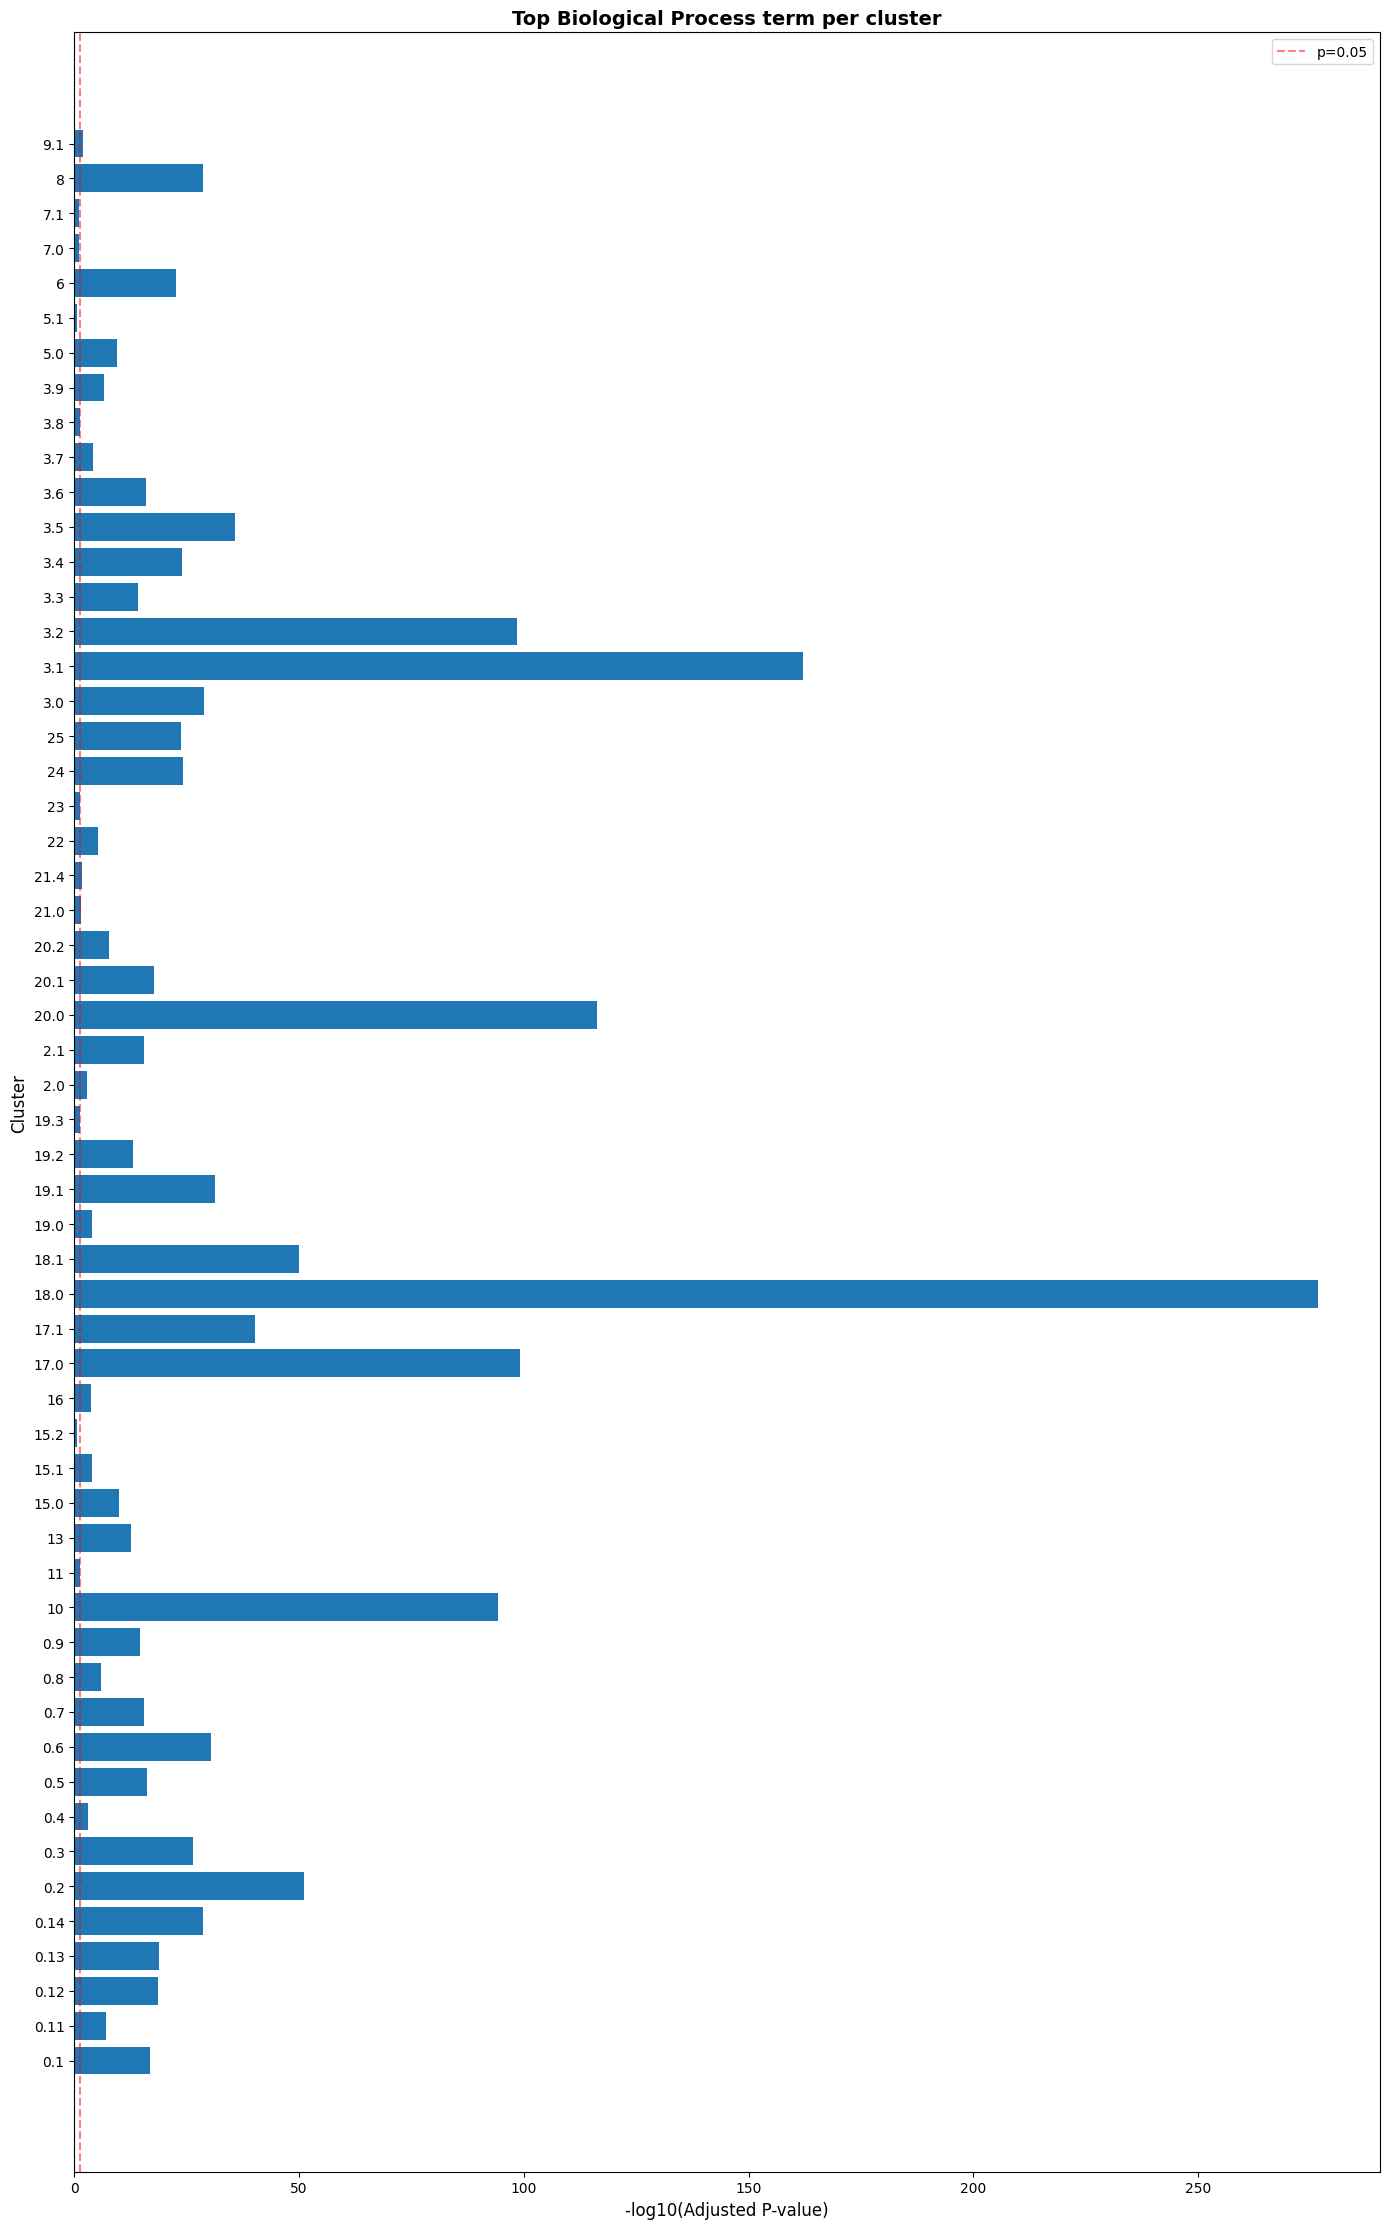

In [ ]:
# import gseapy as gp
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Dictionary to store enrichment results for each cluster
# enrichment_results = {}

# # Get unique clusters
# unique_clusters = adata.obs[KEY_OBS_CLUSTERS].unique()

# print(f"Running GO enrichment for {len(unique_clusters)} clusters...")

# for cluster in tqdm(unique_clusters[1:]):
#     print(f"\nProcessing cluster {cluster}...")
    
#     # Get all proteins in this cluster
#     cluster_mask = adata.obs[KEY_OBS_CLUSTERS] == cluster
#     proteins_in_cluster = adata.obs[cluster_mask]
    
#     # Get gene names for these proteins (filter out None values)
#     gene_names = proteins_in_cluster['gene'].dropna().unique().tolist()
    
#     if len(gene_names) < 3:
#         print(f"  Cluster {cluster}: Too few genes with valid names ({len(gene_names)}), skipping...")
#         continue
    
#     print(f"  Found {len(gene_names)} unique genes in cluster over {len(proteins_in_cluster)} unique proteins.")
    
#     # Run enrichment for each GO category
#     cluster_results = {}
    
#     # Loop
#     for go_library in ["GO_Biological_Process_2021", 
#                        "GO_Cellular_Component_2021",
#                        "GO_Molecular_Function_2021"]:
        
#         try:
#             enr = gp.enrichr(
#                 gene_list=gene_names,
#                 gene_sets=go_library,
#                 organism='human',  
#                 outdir=None,
#                 cutoff=0.05
#             )
            
#             cluster_results[go_library] = enr.results
            
#             # Print top 3 enriched terms
#             if not enr.results.empty:
#                 top_terms = enr.results.head(3)
#                 print(f"\n  Top terms for {go_library}:")
#                 for idx, row in top_terms.iterrows():
#                     print(f"    - {row['Term']}: p={row['Adjusted P-value']:.2e}")
#             else:
#                 print(f"  No significant enrichment for {go_library}")
                
#         except Exception as e:
#             print(f"  Error with {go_library}: {e}")
#             cluster_results[go_library] = pd.DataFrame()
    
#     enrichment_results[cluster] = cluster_results

# print("\n" + "="*50)
# print("Enrichment analysis complete!")
# print(f"Results stored for {len(enrichment_results)} clusters")

# # Create summary dataframe
# summary_data = []
# for cluster, go_results in enrichment_results.items():
#     for go_type, df in go_results.items():
#         if not df.empty and len(df) > 0:
#             top_term = df.iloc[0]
#             summary_data.append({
#                 'Cluster': cluster,
#                 'GO_Category': go_type.replace('GO_', '').replace('_2021', ''),
#                 'Top_Term': top_term['Term'],
#                 'P_value': top_term['Adjusted P-value'],
#                 'N_Significant_Terms': len(df[df['Adjusted P-value'] < 0.05])
#             })

# if summary_data:
#     summary_df = pd.DataFrame(summary_data)
#     print("\nSummary of enrichment results:")
#     print(summary_df.to_string())
    
#     # Optional: Save to CSV
#     summary_df.to_csv('go_enrichment_summary.csv', index=False)
# else:
#     print("\nNo enrichment results found.")

# # Optional: Visualize top term per cluster for Biological Process
# go_category = "GO_Biological_Process_2021"
# plot_data = []

# for cluster in sorted(enrichment_results.keys(), key=lambda x: str(x)):
#     if go_category in enrichment_results[cluster]:
#         results = enrichment_results[cluster][go_category]
#         if not results.empty:
#             top_term = results.iloc[0]
#             plot_data.append({
#                 'Cluster': str(cluster),
#                 'Term': top_term['Term'][:60],  # truncate long terms
#                 'NegLog10P': -np.log10(top_term['Adjusted P-value'])
#             })

# if plot_data:
#     plot_df = pd.DataFrame(plot_data)
    
#     fig, ax = plt.subplots(figsize=(14, max(6, len(plot_data) * 0.4)))
#     bars = ax.barh(plot_df['Cluster'], plot_df['NegLog10P'])
#     ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
#     ax.set_ylabel('Cluster', fontsize=12)
#     ax.set_title(f'Top Biological Process term per cluster', fontsize=14, fontweight='bold')
#     ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', alpha=0.5, label='p=0.05')
#     ax.legend()
#     plt.tight_layout()
#     plt.show()

In [152]:
import gseapy as gp
from gseapy import Msigdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DB_VER="2025.1.Hs"
GENESETS_DB=['h.all', 'c5.all', 'c6.all']# 'c2.cp.reactome']

# Download gene sets locally (only need to do this once)
print("Downloading gene sets...")
msig = Msigdb()

# List available versions
print("\nAvailable versions:", msig.list_dbver())

print("\nAvailable categories:", msig.list_category(dbver=DB_VER))

genesets = {} # dict of dict(geneset aneme : genes)
for g in GENESETS_DB:
    genesets[g] =  msig.get_gmt(category=g, dbver=DB_VER)

genesets


Available versions:          Name     Last modified
0         6.0  2018-12-17 16:29
1         6.1  2018-12-17 16:29
2         6.2  2018-12-17 16:29
3         7.0  2020-01-27 04:43
4         7.1  2020-03-30 16:55
5         7.2  2020-09-18 23:33
6         7.3  2021-03-22 15:09
7         7.4  2021-04-02 14:38
8       7.5.1  2023-03-09 19:38
9         7.5  2022-01-13 01:00
10  2022.1.Hs  2023-03-09 19:37
11  2022.1.Mm  2023-03-09 19:37
12  2023.1.Hs  2023-08-19 15:08
13  2023.1.Mm  2023-08-19 15:09
14  2023.2.Hs  2023-10-21 01:29
15  2023.2.Mm  2023-10-20 08:32
16  2024.1.Hs  2024-09-03 14:38
17  2024.1.Mm  2024-09-03 14:38
18  2025.1.Hs  2025-06-08 14:03
19  2025.1.Mm  2025-06-08 14:03

Available categories: ['c1.all', 'c2.all', 'c2.cgp', 'c2.cp.biocarta', 'c2.cp.kegg_legacy', 'c2.cp.kegg_medicus', 'c2.cp.pid', 'c2.cp.reactome', 'c2.cp', 'c2.cp.wikipathways', 'c3.all', 'c3.mir.mir_legacy', 'c3.mir.mirdb', 'c3.mir', 'c3.tft.gtrd', 'c3.tft.tft_legacy', 'c3.tft', 'c4.3ca', 'c4.all', 'c4.cgn

{'h.all': {'HALLMARK_ADIPOGENESIS': ['ABCA1',
   'ABCB8',
   'ACAA2',
   'ACADL',
   'ACADM',
   'ACADS',
   'ACLY',
   'ACO2',
   'ACOX1',
   'ADCY6',
   'ADIG',
   'ADIPOQ',
   'ADIPOR2',
   'AGPAT3',
   'AIFM1',
   'AK2',
   'ALDH2',
   'ALDOA',
   'ANGPT1',
   'ANGPTL4',
   'APLP2',
   'APOE',
   'ARAF',
   'ARL4A',
   'ATL2',
   'ATP1B3',
   'ATP5PO',
   'BAZ2A',
   'BCKDHA',
   'BCL2L13',
   'BCL6',
   'C3',
   'CAT',
   'CAVIN1',
   'CAVIN2',
   'CCNG2',
   'CD151',
   'CD302',
   'CD36',
   'CDKN2C',
   'CHCHD10',
   'CHUK',
   'CIDEA',
   'CMBL',
   'CMPK1',
   'COL15A1',
   'COL4A1',
   'COQ3',
   'COQ5',
   'COQ9',
   'COX6A1',
   'COX7B',
   'COX8A',
   'CPT2',
   'CRAT',
   'CS',
   'CYC1',
   'CYP4B1',
   'DBT',
   'DDT',
   'DECR1',
   'DGAT1',
   'DHCR7',
   'DHRS7',
   'DHRS7B',
   'DLAT',
   'DLD',
   'DNAJB9',
   'DNAJC15',
   'DRAM2',
   'ECH1',
   'ECHS1',
   'ELMOD3',
   'ELOVL6',
   'ENPP2',
   'EPHX2',
   'ESRRA',
   'ESYT1',
   'ETFB',
   'FABP4',
   'FAH',
   

In [ ]:
def run_enrichment_analysis(adata, cluster_column, genesets_dict, cutoff=0.05, min_genes=3, max_genes=13000):
    """
    Run GO enrichment analysis for each cluster.
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object with protein observations
    cluster_column : str
        Column name in adata.obs containing cluster labels
    genesets_dict : dict
        Dictionary of gene sets from Msigdb (e.g., {'h.all': {...}, 'c5.all': {...}})
    cutoff : float
        Adjusted p-value cutoff (default: 0.05)
    min_genes : int
        Minimum number of genes required per cluster (default: 3)
    
    Returns:
    --------
    results_df : pd.DataFrame
        DataFrame with all enrichment results
    summary_df : pd.DataFrame
        DataFrame with top term per cluster per gene set
    """
    
    enrichment_results = {}
    all_results = []
    unique_clusters = adata.obs[cluster_column].unique()[:5]
    
    print(f"Running enrichment for {len(unique_clusters)} clusters...\n")
    
    # Main enrichment loop
    for cluster in unique_clusters:
        print(f"Cluster {cluster}...")
        
        # Get genes in this cluster
        cluster_mask = adata.obs[cluster_column] == cluster
        gene_names = adata.obs[cluster_mask]['gene'].dropna().unique().tolist()
        gene_names = [g for g in gene_names if g and str(g).strip() != '']
        
        if (len(gene_names) < min_genes) or ((len(gene_names) > max_genes)):
            print(f"  Skipped (only {len(gene_names)} genes)\n")
            continue
        
        print(f"  Testing {len(gene_names)} genes")
        
        # Run enrichment for each gene set
        cluster_results = {}
        
        for geneset_name, geneset_dict in genesets_dict.items():
            
            try:
                # Run enrichment using local gene sets
                enr = gp.enrichr(
                    gene_list=gene_names,
                    gene_sets=geneset_dict,
                    organism='Human',
                    outdir=None,
                    cutoff=cutoff
                )
                
                cluster_results[geneset_name] = enr.results
                
                # Add cluster and geneset info to results
                if not enr.results.empty:
                    n_sig = len(enr.results)
                    print(f"  {geneset_name}: {n_sig} significant terms")
                    
                    # Add results to full results list
                    temp_df = enr.results.copy()
                    temp_df['Cluster'] = cluster
                    temp_df['Gene_Set'] = geneset_name
                    all_results.append(temp_df)
                else:
                    print(f"  {geneset_name}: none")
                    
            except Exception as e:
                print(f"  {geneset_name}: Error - {e}")
                cluster_results[geneset_name] = pd.DataFrame()
        
        enrichment_results[cluster] = cluster_results
        print()
    
    print("="*60)
    print("DONE!\n")
    
    # Create full results DataFrame
    if all_results:
        results_df = pd.concat(all_results, ignore_index=True)
        
        # Reorder columns to put Cluster and Gene_Set first
        cols = ['Cluster', 'Gene_Set'] + [c for c in results_df.columns if c not in ['Cluster', 'Gene_Set']]
        results_df = results_df[cols]
    else:
        results_df = pd.DataFrame()
    
    # Create summary DataFrame (top term per cluster per gene set)
    summary = []
    for cluster, results in enrichment_results.items():
        for geneset_name, df in results.items():
            if not df.empty:
                top = df.iloc[0]
                summary.append({
                    'Cluster': cluster,
                    'Gene_Set': geneset_name,
                    'Top_Term': top['Term'],
                    'P_value': top['Adjusted P-value'],
                    'Overlap': top['Overlap'],
                    'Genes': top['Genes']
                })
    
    summary_df = pd.DataFrame(summary)
    
    return results_df, summary_df


# Run the analysis
results_df, summary_df = run_enrichment_analysis(
    adata=adata,
    cluster_column=KEY_OBS_CLUSTERS,
    genesets_dict=genesets,
    cutoff=0.05,
    min_genes=3
)

# Display summary
print("SUMMARY (Top term per cluster per gene set):")
print(summary_df)
print()

# Save results
# results_df.to_csv('enrichment_full_results.csv', index=False)
# summary_df.to_csv('enrichment_summary.csv', index=False)

print("Saved:")
print("  - enrichment_full_results.csv (all significant terms)")
print("  - enrichment_summary.csv (top term per cluster)")

Running enrichment for 5 clusters...

Cluster 0.0...
  Skipped (only 13515 genes)

Cluster 15.0...
  Testing 429 genes
  h.all: 14 significant terms
  c5.all: 2707 significant terms
  c6.all: 115 significant terms

Cluster 3.0...
  Testing 92 genes
  h.all: 2 significant terms
  c5.all: 1322 significant terms
  c6.all: 79 significant terms

Cluster 3.1...
  Testing 2975 genes
  h.all: 48 significant terms


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/gseapy/enrichr.py:601: RuntimeWarning: divide by zero encountered in log
  odict["Combined Score"] = -1 * log(pvals) * oddr
2025-11-07 17:30:17,992 [ERROR] No hits returned for all input gene sets!


  c5.all: 12517 significant terms
  c6.all: 189 significant terms

Cluster 1...
  Testing 21 genes
  h.all: Error - 'list' object has no attribute 'empty'
  c5.all: 370 significant terms
  c6.all: 8 significant terms

DONE!

SUMMARY (Top term per cluster per gene set):
   Cluster Gene_Set                                Top_Term       P_value  \
0     15.0    h.all                   HALLMARK_ADIPOGENESIS  4.020408e-01   
1     15.0   c5.all  GOBP_3_UTR_MEDIATED_MRNA_STABILIZATION  4.962394e-01   
2     15.0   c6.all                            AKT_UP.V1_DN  7.781622e-01   
3      3.0    h.all            HALLMARK_ALLOGRAFT_REJECTION  8.916959e-02   
4      3.0   c5.all     GOBP_ACTIVATED_T_CELL_PROLIFERATION  1.496101e-02   
5      3.0   c6.all                            ALK_DN.V1_DN  1.714719e-01   
6      3.1    h.all                   HALLMARK_ADIPOGENESIS  1.000000e+00   
7      3.1   c5.all   GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS  1.000000e+00   
8      3.1   c6.all                  

In [156]:
summary_df

Cluster Gene_Set                                Top_Term       P_value  \
0     15.0    h.all                   HALLMARK_ADIPOGENESIS  4.020408e-01   
1     15.0   c5.all  GOBP_3_UTR_MEDIATED_MRNA_STABILIZATION  4.962394e-01   
2     15.0   c6.all                            AKT_UP.V1_DN  7.781622e-01   
3      3.0    h.all            HALLMARK_ALLOGRAFT_REJECTION  8.916959e-02   
4      3.0   c5.all     GOBP_ACTIVATED_T_CELL_PROLIFERATION  1.496101e-02   
5      3.0   c6.all                            ALK_DN.V1_DN  1.714719e-01   
6      3.1    h.all                   HALLMARK_ADIPOGENESIS  1.000000e+00   
7      3.1   c5.all   GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS  1.000000e+00   
8      3.1   c6.all                            AKT_UP.V1_DN  1.376311e-02   
9        1   c5.all      GOBP_ACTIVATION_OF_IMMUNE_RESPONSE  8.743359e-28   
10       1   c6.all                       BCAT.100_UP.V1_DN  8.170401e-02   

   Overlap                                              Genes  
0    1/200                                              RAB34  
1     1/29                                              RBM10  
2    1/187                                           C11orf71  
3    1/200                                               NCR1  
4     3/51                               LILRB4;BTN3A1;BTN2A2  
5    4/139                      CD300C;CEACAM7;LILRA6;CEACAM6  
6   25/200  APOE;CD302;COL4A1;DNAJB9;IFNGR1;SPARCL1;VEGFB;...  
7     1/18                                             COL6A1  
8   49/187  GHR;PLTP;FXYD1;MATN2;MERTK;SERPINF2;ISLR;CD248...  
9   20/621  IGHG4;IGHA2;IGHG3;IGKC;TRGC2;IGLC1;IGHA1;IGHD;...  
10    1/41                                               IGHM

In [ ]:
# Store results
enrichment_results = {}
unique_clusters = adata.obs[KEY_OBS_CLUSTERS].unique()

print(f"Running GO enrichment for {len(unique_clusters)} clusters...\n")

# Main enrichment loop
for cluster in unique_clusters:
    print(f"Cluster {cluster}...")
    
    # Get genes in this cluster
    cluster_mask = adata.obs[KEY_OBS_CLUSTERS] == cluster
    gene_names = adata.obs[cluster_mask]['gene'].dropna().unique().tolist()
    gene_names = [g for g in gene_names if g and str(g).strip() != '']
    
    if len(gene_names) < 3:
        print(f"  Skipped (only {len(gene_names)} genes)\n")
        continue
    
    print(f"  Testing {len(gene_names)} genes")
    
    # Run enrichment for each GO category
    cluster_results = {}
    
    for go_name, go_dict in [("Biological_Process", go_bp), 
                              ("Cellular_Component", go_cc), 
                              ("Molecular_Function", go_mf)]:
        
        try:
            # Run enrichment using local gene sets
            enr = gp.enrichr(
                gene_list=gene_names,
                gene_sets=go_dict,  # Use downloaded gene sets
                organism='Human',
                outdir=None,
                cutoff=0.05
            )
            
            cluster_results[go_name] = enr.results
            
            # Print result
            if not enr.results.empty:
                n_sig = len(enr.results)
                print(f"  {go_name}: {n_sig} significant terms")
            else:
                print(f"  {go_name}: none")
                
        except Exception as e:
            print(f"  {go_name}: Error - {e}")
            cluster_results[go_name] = pd.DataFrame()
    
    enrichment_results[cluster] = cluster_results
    print()

print("="*60)
print("DONE!\n")

# Create summary
summary = []
for cluster, results in enrichment_results.items():
    for go_type, df in results.items():
        if not df.empty:
            top = df.iloc[0]
            summary.append({
                'Cluster': cluster,
                'GO_Type': go_type,
                'Top_Term': top['Term'],
                'P_value': top['Adjusted P-value'],
                'Overlap': top['Overlap']
            })

summary_df = pd.DataFrame(summary)
print(summary_df)
print()

# Save
summary_df.to_csv('go_summary.csv', index=False)
print("Saved to go_summary.csv\n")

# Simple plot: top term per cluster
plot_data = []

for cluster in sorted(enrichment_results.keys(), key=str):
    if "Biological_Process" in enrichment_results[cluster]:
        df = enrichment_results[cluster]["Biological_Process"]
        if not df.empty:
            top = df.iloc[0]
            plot_data.append({
                'Cluster': str(cluster),
                'Term': top['Term'][:40],
                'Score': -np.log10(top['Adjusted P-value'])
            })

if plot_data:
    pdf = pd.DataFrame(plot_data)
    
    fig, ax = plt.subplots(figsize=(10, max(5, len(pdf)*0.4)))
    ax.barh(pdf['Cluster'], pdf['Score'])
    ax.set_xlabel('-log10(p-value)')
    ax.set_ylabel('Cluster')
    ax.set_title('Top Biological Process per Cluster')
    ax.axvline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
    ax.legend()
    plt.tight_layout()
    plt.savefig('go_plot.pdf')
    plt.show()
    print("Saved to go_plot.pdf")

AttributeError: module 'gseapy' has no attribute 'set_cache_path'

# Hierarchical clustering

In [21]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import warnings


from sklearn.metrics import silhouette_samples

def calc_silhouette(indices, X):
    """
    Calculate mean silhouette for a specific cluster.
    Positive = well-separated, Near 0 = blob, Negative = wrong assignment
    """
    if len(indices) < 2:
        return 0.0
    
    rest_indices = list(set(range(len(X))) - set(indices))
    if not rest_indices:
        return 1.0
    
    # Create binary labels: 1 for cluster, 0 for rest
    labels = np.zeros(len(X), dtype=int)
    labels[indices] = 1
    
    # Get silhouette for each sample
    sample_silhouettes = silhouette_samples(X, labels, metric='euclidean')
    
    # Return mean silhouette for the cluster of interest (label=1)
    return np.mean(sample_silhouettes[indices])


def iterative_leiden_clustering(adata, neighbors_key="neighbors_PCA", X_key="X_pca",
                                max_iterations=5, base_resolution=0.1,
                                min_cluster_size=10, silhouette_threshold=0.25):
    """
    Hierarchical clustering that splits well-separated clusters.
    STOPS at cohesive blobs to avoid arbitrary subdivisions.
    """
    X = adata.obsm[X_key]
    
    adata.obs["leiden_iter0"] = "0"
    to_subdivide = {"0": list(adata.obs.index)}
    
    for iteration in range(1, max_iterations + 1):
        if not to_subdivide:
            break
        
        next_to_subdivide = {}
        new_labels = {}
        prev_col = f"leiden_iter{iteration-1}"
        
        for parent, proteins in tqdm(to_subdivide.items(), desc=f"Iteration {iteration}"):
            indices = [adata.obs.index.get_loc(p) for p in proteins]
            sil = calc_silhouette(indices, X)
            
            # Professor's logic: DON'T split cohesive blobs (low silhouette)
            # ONLY split well-separated clusters that have clear substructure
            if len(proteins) < min_cluster_size or sil < silhouette_threshold:
                for p in proteins:
                    new_labels[p] = parent
                continue
            
            # This cluster is well-separated, so we can confidently split it
            adata_sub = adata[proteins].copy()
            n_neighbors = min(15, max(5, len(proteins) // 3))
            
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', message='n_obs too small')
                sc.pp.neighbors(adata_sub, use_rep=X_key, n_neighbors=n_neighbors)
            
            resolution = base_resolution * (1.5 ** (iteration - 1))
            sc.tl.leiden(adata_sub, resolution=resolution, key_added="leiden_sub",
                        flavor="igraph", n_iterations=2)
            
            for sub in adata_sub.obs["leiden_sub"].unique():
                label = f"{parent}.{sub}"
                sub_proteins = adata_sub.obs[adata_sub.obs["leiden_sub"] == sub].index.tolist()
                
                for p in sub_proteins:
                    new_labels[p] = label
                
                if len(sub_proteins) >= min_cluster_size:
                    next_to_subdivide[label] = sub_proteins
        
        adata.obs[f"leiden_iter{iteration}"] = [
            new_labels.get(p, adata.obs.loc[p, prev_col]) for p in adata.obs.index
        ]
        to_subdivide = next_to_subdivide
    
    print(f"✓ {iteration} levels, {adata.obs[f'leiden_iter{iteration}'].nunique()} clusters")
    return adata


def plot_hierarchy(adata, max_iter=4, basis="X_umap_PCA"):
    """Plot UMAP colored by clustering at each iteration level"""
    import matplotlib.pyplot as plt
    
    # Get all leiden_iter columns
    iter_cols = sorted([c for c in adata.obs.columns if c.startswith("leiden_iter")],
                      key=lambda x: int(x.split("iter")[1]))[:max_iter+1]
    
    fig, axes = plt.subplots(1, len(iter_cols), figsize=(6*len(iter_cols), 5))
    axes = [axes] if len(iter_cols) == 1 else axes
    
    for ax, col in zip(axes, iter_cols):
        n_clusters = adata.obs[col].nunique()
        sc.pl.embedding(adata, basis=basis, color=col,
                       title=f"{col}: {n_clusters} clusters",
                       ax=ax, show=False, legend_loc='none')
    plt.tight_layout()
    plt.show()


def summarize_clusters(adata, iteration=None, X_key="X_pca"):
    """Create DataFrame summarizing cluster sizes and quality at given iteration"""
    # Find last iteration if not specified
    if iteration is None:
        iter_cols = [c for c in adata.obs.columns if c.startswith("leiden_iter")]
        iteration = max([int(c.split("iter")[1]) for c in iter_cols])
    
    col = f"leiden_iter{iteration}"
    X = adata.obsm[X_key]
    
    stats = []
    for cluster_id in sorted(adata.obs[col].unique(), key=str):
        proteins = adata.obs[adata.obs[col] == cluster_id].index.tolist()
        indices = [adata.obs.index.get_loc(p) for p in proteins]
        sil = calc_silhouette(indices, X) if len(indices) >= 2 else np.nan
        
        stats.append({
            'cluster': cluster_id,
            'size': len(proteins),
            'silhouette': f"{sil:.3f}" if not np.isnan(sil) else "N/A",
            'sample_proteins': ', '.join(proteins[:3]) + ('...' if len(proteins) > 3 else '')
        })
    
    return pd.DataFrame(stats).sort_values('size', ascending=False)


# ==================== USAGE ====================

# Run clustering
adata = iterative_leiden_clustering(
    adata,
    neighbors_key="neighbors_PCA",
    X_key="X_pca",
    max_iterations=5,
    base_resolution=0.1,
    min_cluster_size=10,
    silhouette_threshold=0.25
)

# Visualize hierarchy
plot_hierarchy(adata, max_iter=4, basis="X_umap_PCA")

# Get cluster summary
df_stats = summarize_clusters(adata, iteration=4, X_key="X_pca")
display(df_stats)

Iteration 1:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration 2:  56%|█████▌    | 10/18 [01:11<00:57,  7.15s/it]


KeyboardInterrupt: 

Iteration 1: 100%|██████████| 1/1 [00:00<00:00, 48.32it/s]

✓ 2 levels, 29 clusters


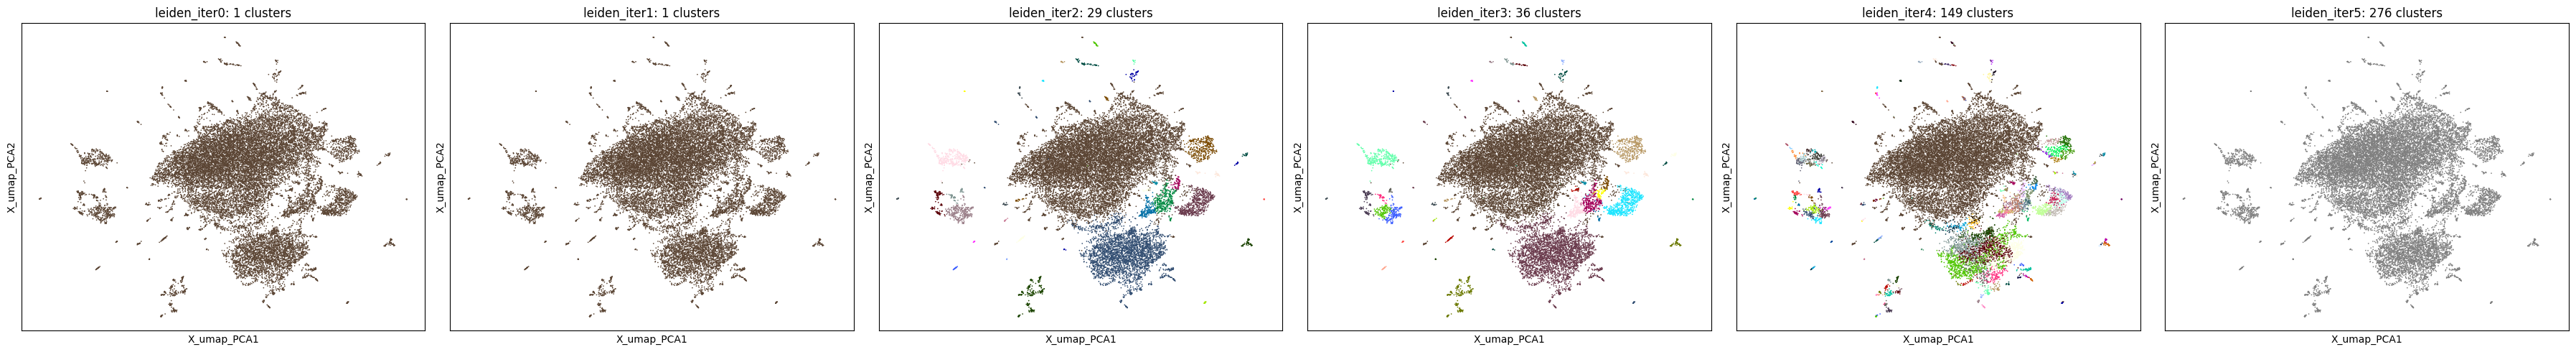

In [16]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples
from tqdm import tqdm
import warnings


def calc_silhouette(indices, X):
    """
    Calculate mean silhouette for a specific cluster.
    > 0.5: Strong separation (well-defined cluster)
    > 0.25: Reasonable separation  
    < 0.25: Overlapping/mixed (contains subgroups)
    """
    if len(indices) < 2:
        return 0.0
    
    rest_indices = list(set(range(len(X))) - set(indices))
    if not rest_indices:
        return 1.0
    
    labels = np.zeros(len(X), dtype=int)
    labels[indices] = 1
    
    sample_silhouettes = silhouette_samples(X, labels, metric='euclidean')
    return np.mean(sample_silhouettes[indices])


def iterative_leiden_clustering(adata, neighbors_key="neighbors_PCA", X_key="X_pca",
                                max_iterations=5, base_resolution=0.1,
                                min_cluster_size=10, silhouette_threshold=0.25):
    """
    Hierarchical clustering that splits overlapping blobs.
    Stops when clusters are well-separated (high silhouette).
    """
    X = adata.obsm[X_key]
    
    adata.obs["leiden_iter0"] = "0"
    to_subdivide = {"0": list(adata.obs.index)}
    
    for iteration in range(1, max_iterations + 1):
        if not to_subdivide:
            break
        
        next_to_subdivide = {}
        new_labels = {}
        prev_col = f"leiden_iter{iteration-1}"
        
        for parent, proteins in tqdm(to_subdivide.items(), desc=f"Iteration {iteration}"):
            indices = [adata.obs.index.get_loc(p) for p in proteins]
            sil = calc_silhouette(indices, X)
            
            # CORRECTED LOGIC:
            # Don't split if: too small OR already well-separated (high silhouette)
            if len(proteins) < min_cluster_size or sil > silhouette_threshold:
                for p in proteins:
                    new_labels[p] = parent
                continue
            
            # Split this cluster (it's overlapping/mixed)
            adata_sub = adata[proteins].copy()
            n_neighbors = min(15, max(5, len(proteins) // 3))
            
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', message='n_obs too small')
                sc.pp.neighbors(adata_sub, use_rep=X_key, n_neighbors=n_neighbors)
            
            resolution = base_resolution * (1.5 ** (iteration - 1))
            sc.tl.leiden(adata_sub, resolution=resolution, key_added="leiden_sub",
                        flavor="igraph", n_iterations=2)
            
            for sub in adata_sub.obs["leiden_sub"].unique():
                label = f"{parent}.{sub}"
                sub_proteins = adata_sub.obs[adata_sub.obs["leiden_sub"] == sub].index.tolist()
                
                for p in sub_proteins:
                    new_labels[p] = label
                
                if len(sub_proteins) >= min_cluster_size:
                    next_to_subdivide[label] = sub_proteins
        
        adata.obs[f"leiden_iter{iteration}"] = [
            new_labels.get(p, adata.obs.loc[p, prev_col]) for p in adata.obs.index
        ]
        to_subdivide = next_to_subdivide
    
    print(f"✓ {iteration} levels, {adata.obs[f'leiden_iter{iteration}'].nunique()} clusters")
    return adata


def plot_hierarchy(adata, max_iter=4, basis="X_umap_PCA"):
    """Plot UMAP colored by clustering at each iteration level"""
    import matplotlib.pyplot as plt
    
    iter_cols = sorted([c for c in adata.obs.columns if c.startswith("leiden_iter")],
                      key=lambda x: int(x.split("iter")[1]))[:max_iter+1]
    
    fig, axes = plt.subplots(1, len(iter_cols), figsize=(6*len(iter_cols), 5))
    axes = [axes] if len(iter_cols) == 1 else axes
    
    for ax, col in zip(axes, iter_cols):
        n_clusters = adata.obs[col].nunique()
        sc.pl.embedding(adata, basis=basis, color=col,
                       title=f"{col}: {n_clusters} clusters",
                       ax=ax, show=False, legend_loc='none')
    plt.tight_layout()
    plt.show()


def summarize_clusters(adata, iteration=None, X_key="X_pca"):
    """Create DataFrame summarizing cluster sizes and quality"""
    if iteration is None:
        iter_cols = [c for c in adata.obs.columns if c.startswith("leiden_iter")]
        iteration = max([int(c.split("iter")[1]) for c in iter_cols])
    
    col = f"leiden_iter{iteration}"
    X = adata.obsm[X_key]
    
    stats = []
    for cluster_id in sorted(adata.obs[col].unique(), key=str):
        proteins = adata.obs[adata.obs[col] == cluster_id].index.tolist()
        indices = [adata.obs.index.get_loc(p) for p in proteins]
        sil = calc_silhouette(indices, X) if len(indices) >= 2 else np.nan
        
        stats.append({
            'cluster': cluster_id,
            'size': len(proteins),
            'silhouette': f"{sil:.3f}" if not np.isnan(sil) else "N/A",
            'sample_proteins': ', '.join(proteins[:3]) + ('...' if len(proteins) > 3 else '')
        })
    
    return pd.DataFrame(stats).sort_values('size', ascending=False)


# ==================== USAGE ====================

adata = iterative_leiden_clustering(
    adata,
    neighbors_key="neighbors_PCA",
    X_key="X_pca",
    max_iterations=10,
    base_resolution=0.1,
    min_cluster_size=10,
    silhouette_threshold=0.25  # Split if silhouette < 0.25
)

plot_hierarchy(adata, max_iter=10, basis="X_umap_PCA")
# df_stats = summarize_clusters(adata, iteration=4, X_key="X_pca")
# display(df_stats)

In [ ]:


# ==================== GO ENRICHMENT FOR EACH CLUSTER ====================

def annotate_clusters_with_go(adata, cluster_tree, iteration, organism="mmusculus"):
    """Run GO enrichment for each cluster"""
    import gseapy as gp
    
    iter_col = f"leiden_iter{iteration}"
    results = {}
    
    for cluster_id in tqdm(adata.obs[iter_col].unique(), desc="GO enrichment"):
        proteins = cluster_tree[iteration][cluster_id]
        
        if len(proteins) < 5:  # Skip tiny clusters
            continue
        
        try:
            enr = gp.enrichr(
                gene_list=proteins,
                gene_sets=['GO_Biological_Process_2021', 'GO_Cellular_Component_2021'],
                organism=organism,
                cutoff=0.05
            )
            
            if not enr.results.empty:
                top_term = enr.results.iloc[0]['Term']
                results[cluster_id] = top_term
                print(f"Cluster {cluster_id} ({len(proteins)} proteins): {top_term}")
        except:
            results[cluster_id] = "No enrichment"
    
    # Add to adata
    adata.obs[f"{iter_col}_annotation"] = adata.obs[iter_col].map(results)
    
    return results

# Run GO enrichment
go_annotations = annotate_clusters_with_go(adata, cluster_tree_pca, iteration=3)